In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
from math import sin, cos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pylab
import time 


In [2]:
t_min = 0 # Tiempo de inicio de lanzamiento
t_MAX = 7 # Tiempo final
delta_t = 0.01 # Paso de tiempo
pos0 = 5 # Posicion en x donde empieza lanzamiento
vel0 = 20 # Velocidad inicial del lanzamiento

In [3]:
#Funcion de tiro parabolico

def simula(t_min,t_max, delta_t, pos0, vel0):
    t = np.linspace(t_min, t_max, (t_max - t_min)/delta_t)
    pos = 0*t
    vel = 0*t
    pos[0] = pos0
    vel[0] = vel0
    k = 10
    m = 10
    b = 10
    F = 0
    flag = False
    for i in range(1,t.size):
        if(flag==True):
            F = 1000 
        else:
            #F = 0
            accel= -9.8 
            #accel = -9.8 -(b/m)*vel[i-1]-(k/m)*(pos[i-1]-100) + F
            vel[i] = vel[i-1] + accel*delta_t # Velocidad con erespecto al tiempo
            pos[i] = pos[i-1] + vel[i]*delta_t # Posicion con respecto al tiempo  
            if (pos[i]<=0):
                flag =True 
            i = i+1
            
            
    return [t,pos,vel]


[t,pos,vel]  = simula(t_min,t_MAX,delta_t,pos0,vel0)

C:\Users\AstridC\Anaconda3\envs\vision_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


In [4]:
dEs= 1 #deviacion estandar del sensor
ruido = np.random.normal(0,dEs, pos.size)

pos_medida = pos+ruido #medicion del sensor


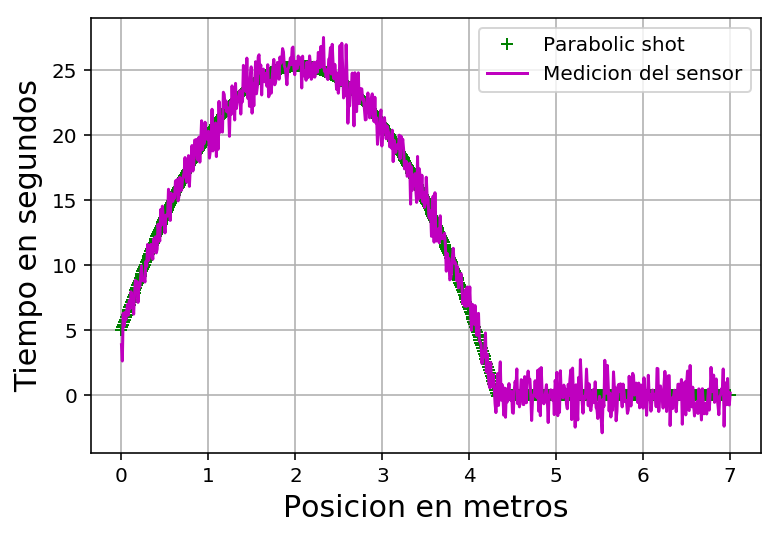

In [5]:
fig, ax = plt.subplots()

ax.plot(t,pos,'g+') #funcion de tiro parabolico
ax.plot(t,pos_medida,'m') # medicion del sensor

ax.grid(True)
ax.legend( ('Parabolic shot','Medicion del sensor'), loc = 'upper right')
plt.xlabel("Posicion en metros", fontsize = 15)
plt.ylabel("Tiempo en segundos", fontsize = 15)
plt.show()

In [6]:
#Funcion de Kalman

class KF:
    def __init__(self,
                 sensor_sigma,             # Sensor noise
                 velocity_sigma,           # Velocity uncertainty
                 position_sigma,           # Position uncertainty
                 dt                        # dt time between samples 
                ):
        
        # Sensor measurement covariance
        self.r_t = np.array([[sensor_sigma**2]])
        
        # Motion model noise for velocity and position
        self.q_t = np.array([[velocity_sigma**2,0.0],
                             [0.0,position_sigma**2]]) 
        self.dt = dt
        
        self.mu = np.array([0.0])
        self.sigma = np.array([0.0])
        
        self.mu_bar = self.mu
        self.sigma_bar = self.sigma

    @property
    def a(self):
        return np.array([[1.0, self.dt],
                         [0, 1.0]])

    @property
    def b(self):
        return np.array([[self.dt],
                         [0.0]])

    def g(self, 
          previous_mu, # Previous mu
          u            # Control input \ddot{z}
          ):
        '''Generates the transition function for the height. '''
        # TODO: return the g matrix using A and B matrixes 
        return np.matmul(self.a, previous_mu) + self.b * u

    def g_prime(self):
        '''The derivative of the transition function.'''
        # TODO: return the derivative of the g matrix
        return np.array([[1.0, self.dt],
                         [0.0, 1.0]]) #A predice posicion


    def initial_values(self, 
                       mu_0, 
                       sigma_0):

        '''Setting initial values for the mu and sigma of the KF'''

        self.mu = mu_0
        self.sigma = sigma_0



    def predict(self, 
                u             # Control input 
               ):

        '''Prediction step of the KF filter '''

        # TODO: Follow the prediction steps outlined in theoretical part of the lesson and implement the next variables. 
        # mu_bar = None
        # g_now  = None
        # sigma_bar = None

        mu_bar = self.g(self.mu, u)
        g_now  = self.g_prime()
        sigma_bar = np.matmul(g_now, np.matmul(self.sigma, np.transpose(g_now))) + self.q_t

        self.mu_bar = mu_bar
        self.sigma_bar = sigma_bar
        return mu_bar, sigma_bar
    
    def h_prime(self):
        return np.array([[1.0, 0.0]])
    
    def h(self,mu):
        return np.matmul(np.array([[1.0, 0.0]]), mu) 

    def update(self, z):
    
        # TODO: Follow the update step outlined in theoretical part of the lesson and implement the next variables. 
        # H = None 
        # K = None
    
        # mu = None
        # sigma = None
    
     
        H = self.h_prime()
        S = np.matmul(np.matmul(H, self.sigma_bar), np.transpose(H)) + self.r_t     
        K = np.matmul(np.matmul(self.sigma_bar, np.transpose(H)), np.linalg.inv(S))
    
        mu = self.mu_bar + np.matmul(K, (z - self.h(self.mu_bar)))
        sigma = np.matmul((np.identity(2) - np.matmul(K, H)), self.sigma_bar)
    
        self.mu = mu
        self.sigma = sigma
    
        return mu, sigma

In [7]:
z = 5                         # Initial position
v = 0.0                         # Initial velocity
dt = 0.01                        # The time difference between measures
sensor_error = 1              # Sensor sigma
velocity_sigma = 0.1            # Velocity uncertaintymatriz de covarianza
position_sigma = 0.1            # Position uncertainty


mu_0 = np.array([[z],
                 [v]]) 

sigma_0 = np.array([[velocity_sigma**2, 0.0],
                    [0.0, position_sigma**2]])

u = np.array([[0.0],
              [0.0]])     # no control input is given \ddot{z} = 0

In [8]:
# Initialize the object
MYKF = KF(sensor_error, velocity_sigma, position_sigma, dt)

# Input the initial values 
MYKF.initial_values(mu_0, sigma_0)

# Call the predict function
#mu_bar, sigma_bar = MYKF.predict(u)

#print('mu_bar = \n', mu_bar)
#print('sigma_bar = \n', sigma_bar)
b_mu=[]
vel_mu=[]
b_mu.append(mu_0[0])
vel_mu.append(mu_0[1])

for i in range(1,t.size):      
    mu_bar, sigma_bar = MYKF.predict(u) 
    mu, sigma= MYKF.update(pos_medida[i])
    b_mu.append(mu[0]) #posicion
    vel_mu.append(mu[1]) #velocidad
            
#b_mu





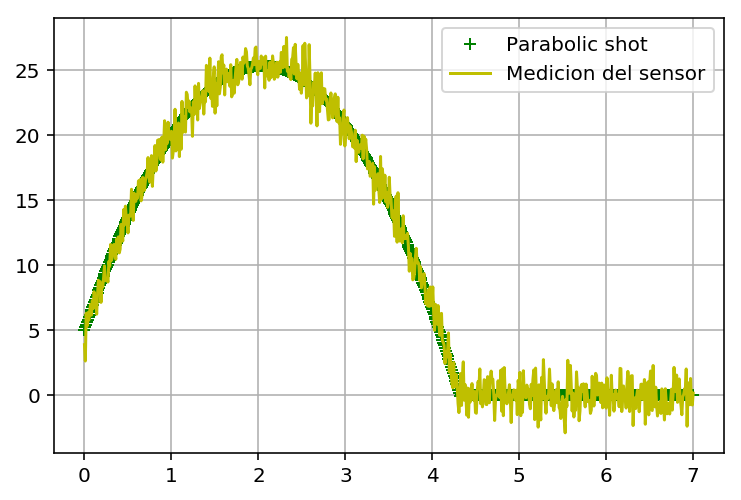

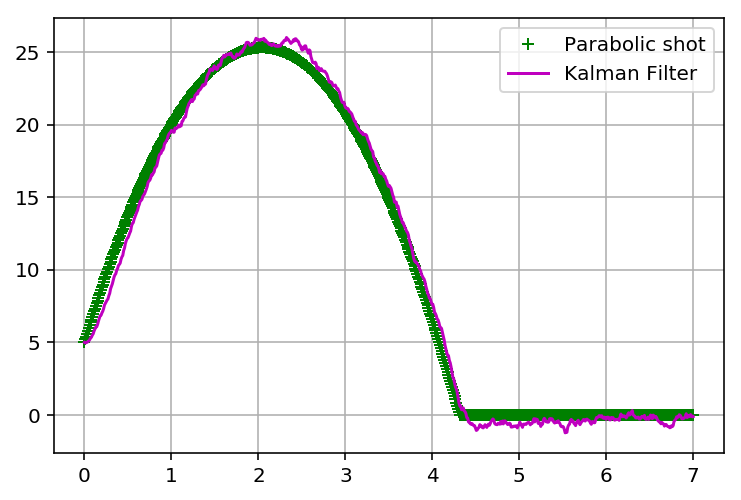

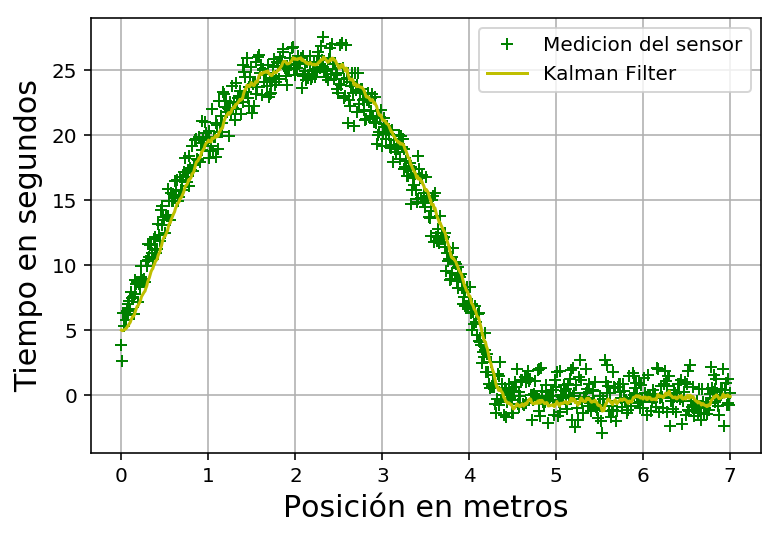

In [17]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
ax.plot(t,pos,'g+') #funcion
ax.plot(t,pos_medida,'y')#medicion del sensor
ax2.plot(t,pos,'g+') #funcion
ax2.plot(t,b_mu,'m')#filtro de kalman
ax3.plot(t,pos_medida,'g+') #medicion del sensor
ax3.plot(t,b_mu,'y')#kalman filter
#ax.plot(t,vel_mu,'b')


ax.grid(True)
ax2.grid(True)
ax3.grid(True)
ax.legend( ('Parabolic shot','Medicion del sensor'), loc = 'upper right')
plt.xlabel("Posición en metros", fontsize = 15)
plt.ylabel("Tiempo en segundos", fontsize = 15)
ax2.legend( ('Parabolic shot','Kalman Filter'), loc = 'upper right')
plt.xlabel("Posición en metros", fontsize = 15)
plt.ylabel("Tiempo en segundos", fontsize = 15)
ax3.legend( ('Medicion del sensor','Kalman Filter'), loc = 'upper right')
plt.xlabel("Posición en metros", fontsize = 15)
plt.ylabel("Tiempo en segundos", fontsize = 15)
plt.show()